## Experiments

5x NM, INM, ANM
total_timesteps : [1_000, 10_000, 50_000, 100_000]


In [63]:
import numpy as np
import matplotlib.pyplot as plt
import gym
import pickle as pkl
import wandb
import pandas as pd
import os
import seaborn as sns

from extension.samplers import NelderMead, ApproximateNelderMead, IncompleteNelderMead
from copy import deepcopy
from pyDOE import lhs
from itertools import combinations, permutations
from sklearn.metrics.pairwise import cosine_similarity
from stable_baselines3.ppo import PPO
from stable_baselines3.common.env_util import make_vec_env, SubprocVecEnv
import matplotlib.patches as patches

## Runs

In [17]:
!python3 train_nm.py -p 'configs/PPO_trials.yaml' -ps 'configs/sampler_config.yaml' -m 'anm'

Initializing simplex...
-----------------------
Number of points: 3
Number of dimensions: 2
Initialization type: lhs
Starting sampling domain: [[0. 0.] - [2. 2.]] x [[0. 0.] - [2. 2.]]
Ratio of aligned vectors: 0.0 / 3.0
Iteration 1 - Good initialization: True

	--- STARTING SIMPLEX EVALUATION ---
wandb: Currently logged in as: mattizza. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Tracking run with wandb version 0.19.2
wandb: Run data is saved locally in /Users/mattia/Documents/University/RL Labs/project-sim2real-gradient-ascm/wandb/run-20250129_142553-mivoaptl
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run polished-resonance-4379
wandb: ⭐️ View project at https://wandb.ai/mattizza/PPO_NM_test
wandb: 🚀 View run at https://wandb.ai/mattizza/PPO_NM_test/runs/mivoaptl
Using cpu device
Logging to runs/mivoaptl/PPO_1
-------------------------------------

In [26]:
with open('data/best_fitnesses.pkl', 'rb') as file:
    best_fitnesses = pkl.load(file)
with open('data/fitnesses.pkl', 'rb') as file:
    fitnesses = pkl.load(file)
with open('data/best_solution.pkl', 'rb') as file:
    best_solution = pkl.load(file)
with open('data/solutions.pkl', 'rb') as file:
    solutions = pkl.load(file)
with open('data/init_points.pkl', 'rb') as file:
    init_points = pkl.load(file)
with open('data/rewards.pkl', 'rb') as file:
    rewards = pkl.load(file)
with open('data/best_rewards.pkl', 'rb') as file:
    best_rewards = pkl.load(file)
with open('data/count_operations.pkl', 'rb') as file:
    count_operations = pkl.load(file)

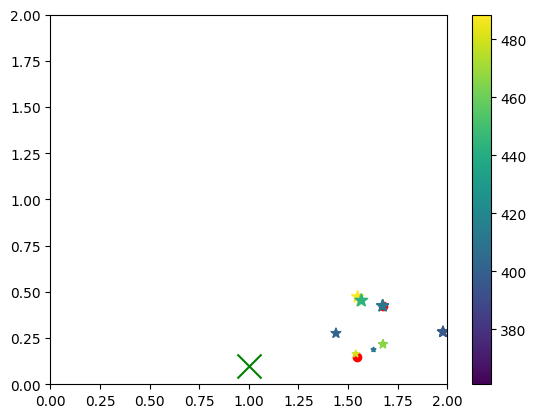

In [27]:
idx = np.arange(len(best_fitnesses))
plt.scatter(1, 0.1, c='g', label='True solution', marker='x', s=300)
plt.scatter(init_points[:, 0], init_points[:, 1], c='r', label='Initial points')
plt.scatter(best_solution[:, 0], best_solution[:, 1], c=best_fitnesses, label='Best solution', marker='*', s=idx * 3)
plt.xlim(0, 2)
plt.ylim(0, 2)
plt.colorbar()

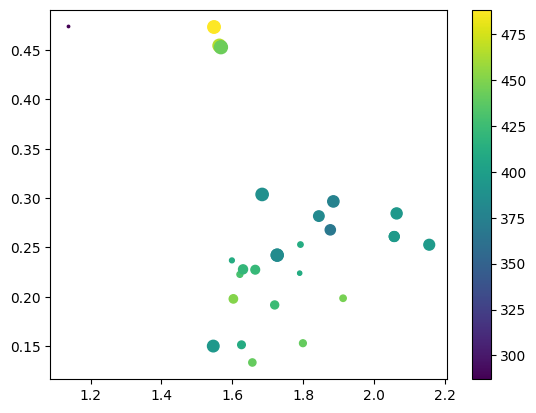

In [28]:
v = 0
vertices = solutions[:, v, :][solutions[:, v, :] != 0].reshape(-1, 2)
rewards_v = fitnesses[:, v][[solutions[:, v, :] > 0][0][:, 0]]
idx = np.arange(len(vertices))
plt.scatter(vertices[:, 0], vertices[:, 1], c=rewards_v, label='Vertices', s=idx * 3)
plt.colorbar()

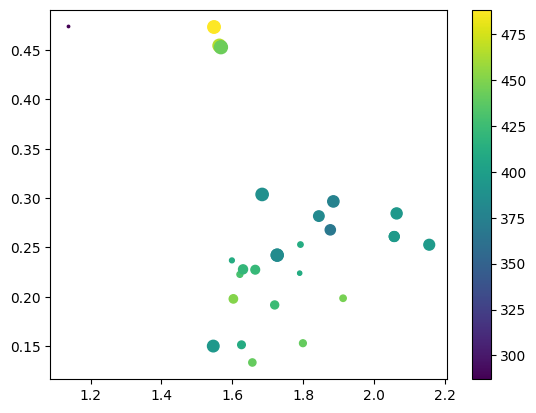

In [29]:
plt.scatter(vertices[:, 0], vertices[:, 1], c=rewards_v, label='Vertices', s=idx * 3)
plt.colorbar()

In [30]:
from matplotlib.cm import get_cmap
import matplotlib.colors as mcolors
vmin = 0
vmax = 50

# Create a Normalize object to scale data values to the interval [0, 1]
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

# Choose a colormap (e.g., 'viridis')
cmap = plt.cm.viridis

# Create a scalar mappable object to map normalized values to colors
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)

cmap = get_cmap('viridis')

/var/folders/h3/8dndlp3j6nd6wc7lltq1hymw0000gn/T/ipykernel_5282/2501212310.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('viridis')


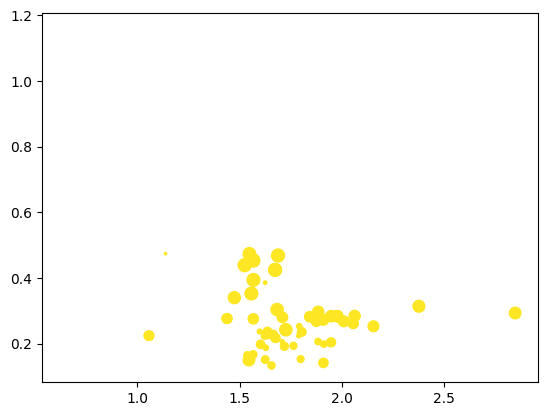

In [31]:
plt.scatter(solutions[:, 0, 0], solutions[:, 0, 1], c=sm.to_rgba(rewards[:, 0]), label='Solutions', s=idx * 3)
plt.scatter(solutions[:, 1, 0], solutions[:, 1, 1], c=sm.to_rgba(rewards[:, 1]), label='Solutions', s=idx * 3)
plt.scatter(solutions[:, 2, 0], solutions[:, 2, 1], c=sm.to_rgba(rewards[:, 2]), label='Solutions', s=idx * 3)

In [32]:
avg_rewards = np.mean(rewards, axis=1)
avg_rewards = avg_rewards[avg_rewards > 0]

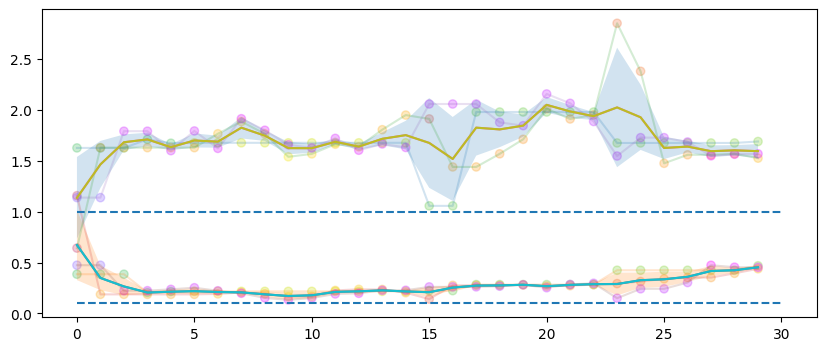

In [33]:
from matplotlib.cm import get_cmap
import matplotlib.colors as mcolors

fig, ax = plt.subplots(1, 1, figsize=(10, 4), alpha = 0.2)

v = 2
vertices = solutions[:, v, :][solutions[:, v, :] != 0].reshape(-1, 2)
rewards_v = fitnesses[:, v][[solutions[:, v, :] > 0][0][:, 0]]

# Create a Normalize object to scale data values to the interval [0, 1]
norm = mcolors.Normalize(vmin=0, vmax=500)

ax.scatter(np.arange(len(vertices)), vertices[:, 0], c=rewards_v, norm=norm, cmap='viridis', alpha = 0.3)
ax.scatter(np.arange(len(vertices)), vertices[:, 1], c=rewards_v, norm=norm, cmap='viridis', alpha = 0.3)
ax.plot(np.arange(len(avg_rewards)), vertices[:, 0], label='Average reward', alpha = 0.2)
ax.plot(np.arange(len(avg_rewards)), vertices[:, 1], label='Average reward', alpha = 0.2)

v = 1
vertices = solutions[:, v, :][solutions[:, v, :] != 0].reshape(-1, 2)
rewards_v = fitnesses[:, v][[solutions[:, v, :] > 0][0][:, 0]]

# Create a Normalize object to scale data values to the interval [0, 1]
norm = mcolors.Normalize(vmin=0, vmax=500)

ax.scatter(np.arange(len(vertices)), vertices[:, 0], c=rewards_v, norm=norm, cmap='plasma', alpha = 0.3)
ax.scatter(np.arange(len(vertices)), vertices[:, 1], c=rewards_v, norm=norm, cmap='plasma', alpha = 0.3)
ax.plot(np.arange(len(avg_rewards)), vertices[:, 0], label='Average reward', alpha = 0.2)
ax.plot(np.arange(len(avg_rewards)), vertices[:, 1], label='Average reward', alpha = 0.2)

v = 0
vertices = solutions[:, v, :][solutions[:, v, :] != 0].reshape(-1, 2)
rewards_v = fitnesses[:, v][[solutions[:, v, :] > 0][0][:, 0]]

avg_vertices = np.mean(vertices, axis=0)

# Create a Normalize object to scale data values to the interval [0, 1]
norm = mcolors.Normalize(vmin=0, vmax=500)

ax.scatter(np.arange(len(vertices)), vertices[:, 0], c=rewards_v, norm=norm, cmap='cool', alpha = 0.3)
ax.scatter(np.arange(len(vertices)), vertices[:, 1], c=rewards_v, norm=norm, cmap='cool', alpha = 0.3)

ax.plot(np.arange(len(avg_rewards)), vertices[:, 0], label='Average reward', alpha = 0.2)
ax.plot(np.arange(len(avg_rewards)), vertices[:, 1], label='Average reward', alpha = 0.2)
avg_v = np.mean(solutions, axis = 1)
std_v = np.std(solutions[:, :, 0], axis = 1)
ax.plot(avg_v)
ax.fill_between(np.arange(len(avg_v)), avg_v[:, 0] - std_v, avg_v[:, 0] + std_v, alpha = 0.2)

std_v = np.std(solutions[:, :, 1], axis = 1)
ax.plot(avg_v)
ax.fill_between(np.arange(len(avg_v)), avg_v[:, 1] - std_v, avg_v[:, 1] + std_v, alpha = 0.2)



ax.hlines(y = 0.1, xmin=0, xmax=len(vertices), label='True solution', linestyle='--')
ax.hlines(y = 1, xmin=0, xmax=len(vertices), label='True solution', linestyle='--')

In [11]:
v = 0
vertices = solutions[:, v, :][solutions[:, v, :] != 0].reshape(-1, 2)
rewards_v = fitnesses[:, v][[solutions[:, v, :] > 0][0][:, 0]]
avg_0 = np.average(vertices, axis=0, weights=rewards_v)

v = 1
vertices = solutions[:, v, :][solutions[:, v, :] != 0].reshape(-1, 2)
rewards_v = fitnesses[:, v][[solutions[:, v, :] > 0][0][:, 0]]
avg_1 = np.average(vertices, axis=0, weights=rewards_v)

v = 2
vertices = solutions[:, v, :][solutions[:, v, :] != 0].reshape(-1, 2)
rewards_v = fitnesses[:, v][[solutions[:, v, :] > 0][0][:, 0]]
avg_2 = np.average(vertices, axis=0, weights=rewards_v)

In [12]:
np.mean([avg_0, avg_1, avg_2], axis=0)

array([1.54525116, 0.36048621])

In [13]:
np.mean(np.mean(solutions, axis=0), axis=0)

array([1.51828993, 0.36767401])

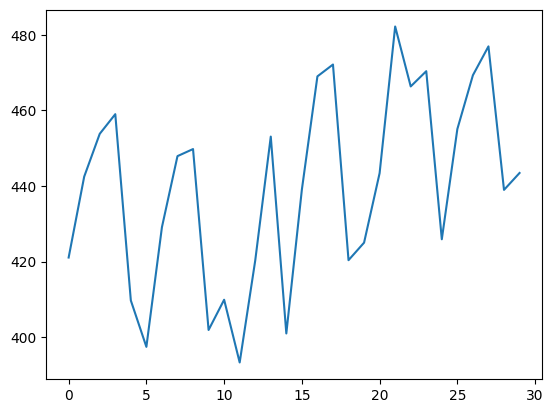

In [14]:
# plt.plot(np.max(rewards, axis = 1))
# plt.plot(np.min(rewards, axis = 1))
plt.plot(np.mean(rewards, axis = 1))

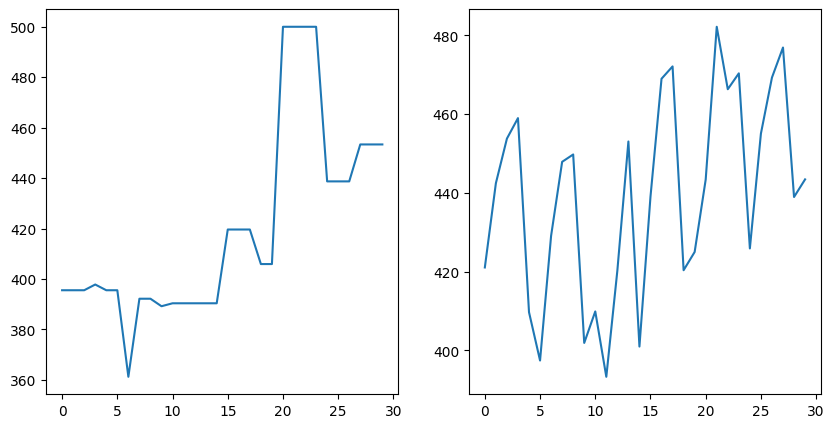

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(best_fitnesses)
ax[1].plot(avg_rewards)

ValueError: s must be a scalar, or float array-like with the same size as x and y

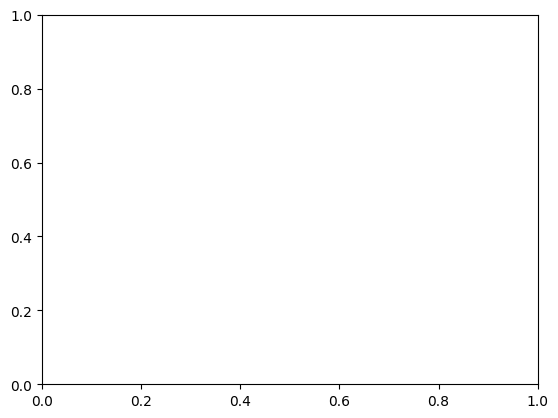

In [12]:
plt.scatter(best_solution[:, 0],
            best_solution[:, 1],
            c=sm.to_rgba(best_rewards),
            label='Best solution', 
            marker='*', 
            s=idx * 3)
plt.colorbar()

In [3]:
env_id = "CartPole-v1"
env = make_vec_env(env_id, n_envs=16, seed=42, vec_env_cls=SubprocVecEnv)
model = PPO(env=env, 
            verbose=1,
            normalize_advantage=True,
            n_steps=256,
            policy='MlpPolicy',
            gae_lambda=0.94,
            gamma=0.99,
            n_epochs=4,
            ent_coef=0.0,
            device='cpu')
model.learn(total_timesteps=1_000_000)

Using cpu device
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.1     |
|    ep_rew_mean     | 20.1     |
| time/              |          |
|    fps             | 21311    |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 4096     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 26.1        |
|    ep_rew_mean          | 26.1        |
| time/                   |             |
|    fps                  | 9204        |
|    iterations           | 2           |
|    time_elapsed         | 0           |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.007211308 |
|    clip_fraction        | 0.0809      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.687      |
|    explained_variance   | -0.00423    |
|    learning

KeyboardInterrupt: 

In [ ]:
import numpy as np

# Define the object to be used for initialization
initial_object = [1, 2, 3]

# Define the shape of the array
array_shape = (3, 3)

# Initialize the array with the same object
array_with_objects = np.full(array_shape, initial_object, dtype=object)

print("Array with the same object in each element:")
print(array_with_objects)

In [ ]:
solution = np.array([25, 100])
best_solution = np.array([9, 2])

args = {
    'n_points' : 3,
    'n_dim' : 2,
    'initialization' : 'lhs',
    'solution' : solution,
    'max_iter' : 100,
    'domain_min' : 0,
    'domain_max' : 300,
    'weight_by_distance' : False,
    'ratio_high_cosine' : 0.1,
    'threshold' : -2,
    'sigma_noise' : 5,
    'max_init' : 10,
    'pulse' : True,
    'expanding_domain_factor' : 0.6,
    'max_shrink' : 3
}
solver = IncompleteNelderMead(args=args)
all_solutions, all_fitnesses, best_solutions, init_points = solver.search()

(0.0, 2.0)

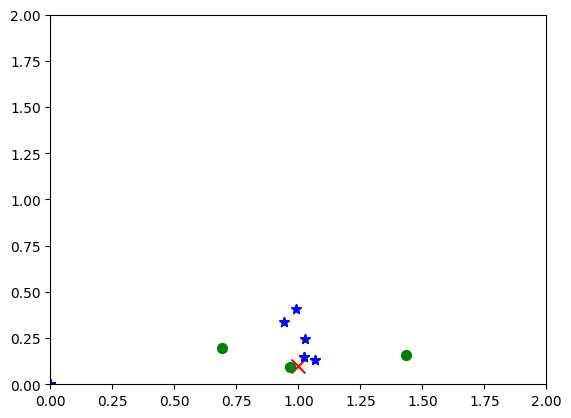

In [9]:
plt.scatter(1, 0.1, c='r', label='Solution', marker='x', s = 100)
plt.scatter(best_solution[:, 0], best_solution[:, 1], c='b', label='Best Solutions', marker='*', s = 50)
plt.scatter(init_points[:, 0], init_points[:, 1], c='g', label='Initial Points', marker='o', s = 50)
plt.xlim(0, 2)
plt.ylim(0, 2)

In [ ]:
plt.plot(all_fitnesses)
plt.plot(np.max(all_fitnesses, axis=1), c='r', label='Best Fitness')
plt.legend()

In [ ]:
plt.fill(np.append(init_points[:, 0], init_points[0, 0]), np.append(init_points[:, 1], init_points[0, 1]), color='lightgreen', alpha=0.5)
plt.plot(np.append(init_points[:, 0], init_points[0, 0]), np.append(init_points[:, 1], init_points[0, 1]), color='green', linewidth=1)
plt.scatter(init_points[:, 0], init_points[:, 1], color='green', s = 100)  # Mark vertices

for i in range(all_solutions.shape[0]):
    x_coords = all_solutions[i, :, 0]
    y_coords = all_solutions[i, :, 1]
    plt.fill(np.append(x_coords, x_coords[0]), np.append(y_coords, y_coords[0]), color='lightblue', alpha=0.5)
    plt.plot(np.append(x_coords, x_coords[0]), np.append(y_coords, y_coords[0]), color='blue', linewidth=1)
    plt.scatter(x_coords, y_coords, color='red')  # Mark vertices
    plt.scatter(best_solutions[i, 0], best_solutions[i, 1], c='b', marker='*', s = 50)

plt.scatter(*solution, c='r', label='Solution', marker='x', s = 100)

## Analysis

In [64]:
# NOTE: this is ugly? Yes
folder_path_nm = 'data/NM/80k_default'
files_nm = os.listdir(folder_path_nm)
all_data_nm = []

for folder_number, method_folder in enumerate(files_nm):
    file_path = os.path.join(folder_path_nm, method_folder)
    print(os.listdir(file_path))
    for file in os.listdir(file_path):    
        file_path_data = os.path.join(file_path, file)
        with open(file_path_data, 'rb') as f:
            content = pkl.load(f, encoding='latin1')
            all_data_nm.append(content)

folder_path_inm = 'data/INM'
files_inm = os.listdir(folder_path_inm)
all_data_inm = []
for folder_number, method_folder in enumerate(files_inm):
    file_path = os.path.join(folder_path_inm, method_folder)
    print(os.listdir(file_path))
    for file in os.listdir(file_path):    
        file_path_data = os.path.join(file_path, file)
        with open(file_path_data, 'rb') as f:
            content = pkl.load(f, encoding='latin1')
            all_data_inm.append(content)

folder_path_anm_w = 'data/ANM/weights'
files_anm_w = os.listdir(folder_path_anm_w)
all_data_anm_w = []
for folder_number, method_folder in enumerate(files_anm_w):
    file_path = os.path.join(folder_path_anm_w, method_folder)
    print(os.listdir(file_path))
    for file in os.listdir(file_path):    
        file_path_data = os.path.join(file_path, file)
        with open(file_path_data, 'rb') as f:
            content = pkl.load(f, encoding='latin1')
            all_data_anm_w.append(content)

folder_path_anm_d = 'data/ANM/distance'
files_anm_d = os.listdir(folder_path_anm_d)
all_data_anm_d = []
for folder_number, method_folder in enumerate(files_anm_d):
    file_path = os.path.join(folder_path_anm_d, method_folder)
    print(os.listdir(file_path))
    for file in os.listdir(file_path):    
        file_path_data = os.path.join(file_path, file)
        with open(file_path_data, 'rb') as f:
            content = pkl.load(f, encoding='latin1')
            all_data_anm_d.append(content)

['best_fitnesses.pkl', 'rewards.pkl', 'fitnesses.pkl', 'count_operations.pkl', 'init_points.pkl', 'best_solution.pkl', 'best_rewards.pkl', 'solutions.pkl']
['best_fitnesses.pkl', 'rewards.pkl', 'fitnesses.pkl', 'count_operations.pkl', 'init_points.pkl', 'best_solution.pkl', 'best_rewards.pkl', 'solutions.pkl']
['best_fitnesses.pkl', 'rewards.pkl', 'fitnesses.pkl', 'count_operations.pkl', 'init_points.pkl', 'best_solution.pkl', 'best_rewards.pkl', 'solutions.pkl']
['best_fitnesses.pkl', 'rewards.pkl', 'fitnesses.pkl', 'count_operations.pkl', 'init_points.pkl', 'best_solution.pkl', 'best_rewards.pkl', 'solutions.pkl']
['best_fitnesses.pkl', 'rewards.pkl', 'fitnesses.pkl', 'count_operations.pkl', 'init_points.pkl', 'best_solution.pkl', 'best_rewards.pkl', 'solutions.pkl']
['best_fitnesses.pkl', 'rewards.pkl', 'fitnesses.pkl', 'count_operations.pkl', 'init_points.pkl', 'best_solution.pkl', 'best_rewards.pkl', 'solutions.pkl']
['best_fitnesses.pkl', 'rewards.pkl', 'fitnesses.pkl', 'count_op

In [65]:
best_fitnesses_nm = np.array([all_data_nm[i] for i in np.arange(0, 40, 8)])
rewards_nm = np.array([all_data_nm[i] for i in np.arange(1, 40, 8)])
fitnesses_nm = np.array([all_data_nm[i] for i in np.arange(2, 40, 8)])
count_operations_nm = np.array([all_data_nm[i] for i in np.arange(3, 40, 8)])
init_points_nm = np.array([all_data_nm[i] for i in np.arange(4, 40, 8)])
best_solutions_nm = np.array([all_data_nm[i] for i in np.arange(5, 40, 8)])
best_rewards_nm = np.array([all_data_nm[i] for i in np.arange(6, 40, 8)])
solutions_nm = np.array([all_data_nm[i] for i in np.arange(7, 40, 8)])

best_fitnesses_inm = np.array([all_data_inm[i] for i in np.arange(0, 40, 8)])
rewards_inm = np.array([all_data_inm[i] for i in np.arange(1, 40, 8)])
fitnesses_inm = np.array([all_data_inm[i] for i in np.arange(2, 40, 8)])
count_operations_inm = np.array([all_data_inm[i] for i in np.arange(3, 40, 8)])
init_points_inm = np.array([all_data_inm[i] for i in np.arange(4, 40, 8)])
best_solutions_inm = np.array([all_data_inm[i] for i in np.arange(5, 40, 8)])
best_rewards_inm = np.array([all_data_inm[i] for i in np.arange(6, 40, 8)])
solutions_inm = np.array([all_data_inm[i] for i in np.arange(7, 40, 8)])

best_fitnesses_anm_w = np.array([all_data_anm_w[i] for i in np.arange(0, 40, 8)])
rewards_anm_w = np.array([all_data_anm_w[i] for i in np.arange(1, 40, 8)])
fitnesses_anm_w = np.array([all_data_anm_w[i] for i in np.arange(2, 40, 8)])
count_operations_anm_w = np.array([all_data_anm_w[i] for i in np.arange(3, 40, 8)])
init_points_anm_w = np.array([all_data_anm_w[i] for i in np.arange(4, 40, 8)])
best_solutions_anm_w = np.array([all_data_anm_w[i] for i in np.arange(5, 40, 8)])
best_rewards_anm_w = np.array([all_data_anm_w[i] for i in np.arange(6, 40, 8)])
solutions_anm_w = np.array([all_data_anm_w[i] for i in np.arange(7, 40, 8)])

best_fitnesses_anm_d = np.array([all_data_anm_d[i] for i in np.arange(0, 40, 8)])
rewards_anm_d = np.array([all_data_anm_d[i] for i in np.arange(1, 40, 8)])
fitnesses_anm_d = np.array([all_data_anm_d[i] for i in np.arange(2, 40, 8)])
count_operations_anm_d = np.array([all_data_anm_d[i] for i in np.arange(3, 40, 8)])
init_points_anm_d = np.array([all_data_anm_d[i] for i in np.arange(4, 40, 8)])
best_solutions_anm_d = np.array([all_data_anm_d[i] for i in np.arange(5, 40, 8)])
best_rewards_anm_d = np.array([all_data_anm_d[i] for i in np.arange(6, 40, 8)])
solutions_anm_d = np.array([all_data_anm_d[i] for i in np.arange(7, 40, 8)])

In [66]:
avg_f_nm = np.mean(fitnesses_nm)
std_f_nm = np.std(fitnesses_nm)
avg_f_inm = np.mean(fitnesses_inm)
std_f_inm = np.std(fitnesses_inm)
avg_f_anm_w = np.mean(fitnesses_anm_w)
std_f_anm_w = np.std(fitnesses_anm_w)
avg_f_anm_d = np.mean(fitnesses_anm_d)
std_f_anm_d = np.std(fitnesses_anm_d)
print(f'NM: {avg_f_nm} +- {std_f_nm}')
print(f'INM: {avg_f_inm} +- {std_f_inm}')
print(f'ANM w: {avg_f_anm_w} +- {std_f_anm_w}')
print(f'ANM d: {avg_f_anm_d} +- {std_f_anm_d}')
# np.mean(np.mean(np.mean(solutions_nm[:, 28:, :, :], axis = 0), axis = 0), axis = 0)
# np.std(np.std(np.std(solutions_nm[:, 15:, :, :], axis = 0), axis = 0), axis = 0)
points_sol = np.random.multivariate_normal([1, 0.1], [[0.0035, 0], [0, 0.0035]], 10_000)

NM: 392.19842301415235 +- 61.49087820778375
INM: 425.87237207633393 +- 47.57151496518874
ANM w: 387.1617998941403 +- 65.90265604138237
ANM d: 400.7934871069471 +- 46.84655100121035


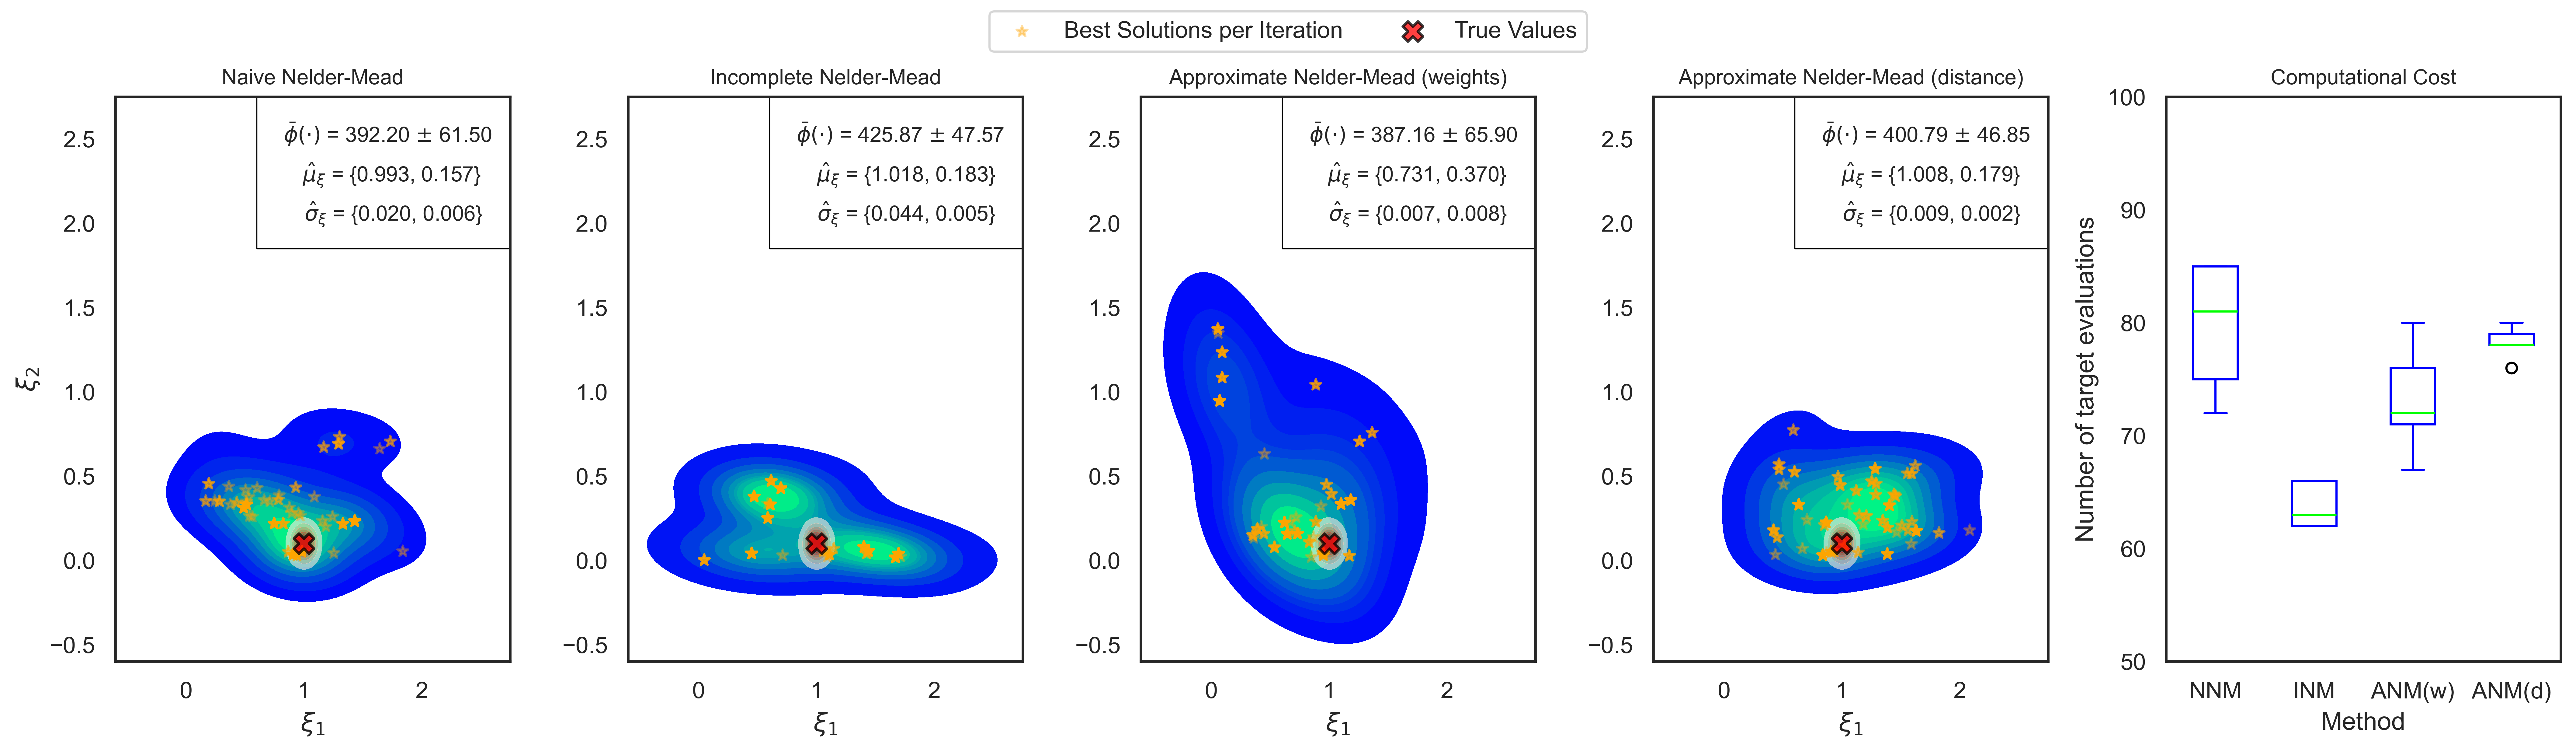

In [74]:
fig, ax = plt.subplots(1, 5, figsize=(18, 5), dpi=500)

idx = np.arange(best_fitnesses_nm.shape[1])

sns.kdeplot(x = solutions_nm.reshape(-1, 2)[:, 0], y = solutions_nm.reshape(-1, 2)[:, 1], fill=True, levels=10, cmap='winter', ax = ax[0], bw_adjust=1.75)
sns.kdeplot(x = solutions_inm.reshape(-1, 2)[:, 0], y = solutions_inm.reshape(-1, 2)[:, 1], fill=True, levels=10, cmap='winter', ax = ax[1], bw_adjust=1.75)
sns.kdeplot(x = solutions_anm_w.reshape(-1, 2)[:, 0], y = solutions_anm_w.reshape(-1, 2)[:, 1], fill=True, levels=10, cmap='winter', ax = ax[2], bw_adjust=1.75)
sns.kdeplot(x = solutions_anm_d.reshape(-1, 2)[:, 0], y = solutions_anm_d.reshape(-1, 2)[:, 1], fill=True, levels=10, cmap='winter', ax = ax[3], bw_adjust=1.75)

sns.kdeplot(x = points_sol[:, 0], y = points_sol[:, 1], fill=True, levels=8, cmap='Reds', ax = ax[0], bw_adjust=2.5, thresh=0.075, alpha=0.6)
sns.kdeplot(x = points_sol[:, 0], y = points_sol[:, 1], fill=True, levels=8, cmap='Reds', ax = ax[1], bw_adjust=2.5, thresh=0.075, alpha=0.6)
sns.kdeplot(x = points_sol[:, 0], y = points_sol[:, 1], fill=True, levels=8, cmap='Reds', ax = ax[2], bw_adjust=2.5, thresh=0.075, alpha=0.6)
sns.kdeplot(x = points_sol[:, 0], y = points_sol[:, 1], fill=True, levels=8, cmap='Reds', ax = ax[3], bw_adjust=2.5, thresh=0.075, alpha=0.6)

ax[0].scatter(best_solutions_nm[:, :, 0], best_solutions_nm[:, :, 1], label='Best Solutions per Iteration', marker='*', s = 30, c='orange', alpha=0.35)
ax[1].scatter(best_solutions_inm[:, :, 0], best_solutions_inm[:, :, 1], label='Best Solutions per Iteration', marker='*', s = 30, c='orange', alpha=0.35)
ax[2].scatter(best_solutions_anm_w[:, :, 0], best_solutions_anm_w[:, :, 1], label='Best Solutions per Iteration', marker='*', s = 30, c='orange', alpha=0.35)
ax[3].scatter(best_solutions_anm_d[:, :, 0], best_solutions_anm_d[:, :, 1], label='Best Solutions per Iteration', marker='*', s = 30, c='orange', alpha=0.35)

ax[0].scatter(1, 0.1, c='red', label='True Values', marker='X', s = 90, edgecolors='black', linewidths=1.25, alpha=0.75)
ax[1].scatter(1, 0.1, c='red', label='True Values', marker='X', s = 90, edgecolors='black', linewidths=1.25, alpha=0.75)
ax[2].scatter(1, 0.1, c='red', label='True Values', marker='X', s = 90, edgecolors='black', linewidths=1.25, alpha=0.75)
ax[3].scatter(1, 0.1, c='red', label='True Values', marker='X', s = 90, edgecolors='black', linewidths=1.25, alpha=0.75)

ax[0].set_xlim(-0.6, 2.75)
ax[0].set_ylim(-0.6, 2.75)
ax[1].set_xlim(-0.6, 2.75)
ax[1].set_ylim(-0.6, 2.75)
ax[2].set_xlim(-0.6, 2.75)
ax[2].set_ylim(-0.6, 2.75)
ax[3].set_xlim(-0.6, 2.75)
ax[3].set_ylim(-0.6, 2.75)
ax[4].set_ylim(50, 100)

_ = ax[4].boxplot([count_operations_nm, count_operations_inm, count_operations_anm_w, count_operations_anm_d],
                  tick_labels=['NNM', 'INM', 'ANM(w)', 'ANM(d)'], patch_artist=True, 
                  boxprops=dict(facecolor='white', color='blue'), 
                  whiskerprops=dict(color='blue'), 
                  capprops=dict(color='blue'), 
                  medianprops=dict(color='lime'), 
                  flierprops=dict(marker='o', markerfacecolor='white', markersize=5, linestyle='none'))

ax[0].set_title('Naive Nelder-Mead', fontsize=10)
ax[1].set_title('Incomplete Nelder-Mead', fontsize=10)
ax[2].set_title('Approximate Nelder-Mead (weights)', fontsize=10)
ax[3].set_title('Approximate Nelder-Mead (distance)', fontsize=10)
ax[4].set_title('Computational Cost', fontsize=10)

ax[0].set_xlabel(r'$\xi_{1}$')
ax[1].set_xlabel(r'$\xi_{1}$')
ax[2].set_xlabel(r'$\xi_{1}$')
ax[3].set_xlabel(r'$\xi_{1}$')
ax[0].set_ylabel(r'$\xi_{2}$')
ax[4].set_xlabel('Method')
ax[4].set_ylabel('Number of target evaluations')


ax[0].text(0.69, 0.92, r'$\bar{\phi}(\cdot)$ = 392.20 $\pm$ 61.50', horizontalalignment='center', fontsize=10, transform=ax[0].transAxes)
ax[0].text(0.70, 0.85, r'$\hat{\mu}_{\xi}$ = {0.993, 0.157}', horizontalalignment='center', fontsize=10, transform=ax[0].transAxes)
ax[0].text(0.705, 0.78, r'$\hat{\sigma}_{\xi}$ = {0.020, 0.006}', horizontalalignment='center', fontsize=10, transform=ax[0].transAxes)

ax[1].text(0.69, 0.92, r'$\bar{\phi}(\cdot)$ = 425.87 $\pm$ 47.57', horizontalalignment='center', fontsize=10, transform=ax[1].transAxes)
ax[1].text(0.705, 0.85, r'$\hat{\mu}_{\xi}$ = {1.018, 0.183}', horizontalalignment='center', fontsize=10, transform=ax[1].transAxes)
ax[1].text(0.705, 0.78, r'$\hat{\sigma}_{\xi}$ = {0.044, 0.005}', horizontalalignment='center', fontsize=10, transform=ax[1].transAxes)

ax[2].text(0.69, 0.92, r'$\bar{\phi}(\cdot)$ = 387.16 $\pm$ 65.90', horizontalalignment='center', fontsize=10, transform=ax[2].transAxes)
ax[2].text(0.70, 0.85, r'$\hat{\mu}_{\xi}$ = {0.731, 0.370}', horizontalalignment='center', fontsize=10, transform=ax[2].transAxes)
ax[2].text(0.7025, 0.78, r'$\hat{\sigma}_{\xi}$ = {0.007, 0.008}', horizontalalignment='center', fontsize=10, transform=ax[2].transAxes)

ax[3].text(0.69, 0.92, r'$\bar{\phi}(\cdot)$ = 400.79 $\pm$ 46.85', horizontalalignment='center', fontsize=10, transform=ax[3].transAxes)
ax[3].text(0.7025, 0.85, r'$\hat{\mu}_{\xi}$ = {1.008, 0.179}', horizontalalignment='center', fontsize=10, transform=ax[3].transAxes)
ax[3].text(0.705, 0.78, r'$\hat{\sigma}_{\xi}$ = {0.009, 0.002}', horizontalalignment='center', fontsize=10, transform=ax[3].transAxes)

rect = patches.Rectangle((0.6, 1.85), 3, 2, linewidth=0.5, edgecolor='black', facecolor='none')
ax[0].add_patch(rect)
rect = patches.Rectangle((0.6, 1.85), 3, 2, linewidth=0.5, edgecolor='black', facecolor='none')
ax[1].add_patch(rect)
rect = patches.Rectangle((0.6, 1.85), 3, 2, linewidth=0.5, edgecolor='black', facecolor='none')
ax[2].add_patch(rect)
rect = patches.Rectangle((0.6, 1.85), 3, 2, linewidth=0.5, edgecolor='black', facecolor='none')
ax[3].add_patch(rect)
fig.tight_layout(rect=(0,0,0.95,0.95))

handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, ncols = 2, loc='upper center')
plt.savefig('figure1.pdf')